In [40]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from scipy.special import erfc
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from torch.optim import SGD, Adam
from tqdm import tqdm
from utils import Encoder, Decoder, awgn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [41]:
M = 16 # number of constellation points
flag_train_model = False # True: train model, False: load pre-trained model
Path = "./models/ae_simo_rayleigh_16qam.pth"
encoder = Encoder([M, 64, 64, 64, 2]).to(device)
decoder = Decoder([8, 512, 512, 512, M]).to(device)

In [42]:
if not flag_train_model:
    # read model if exists else train model
    checkpoint = torch.load(Path, map_location=torch.device('cpu'))
    encoder.load_state_dict(checkpoint["Encoder"])
    decoder.load_state_dict(checkpoint["Decoder"])
    print("Model loaded")

Model loaded


In [ ]:
if flag_train_model:
    train_snr = 15 # training SNR in dB
    criterion = nn.NLLLoss()     # negative log likelihood loss
    para = list(encoder.parameters()) + list(decoder.parameters())  # get all parameters
    opt = Adam(para, lr=0.01)
    loss = []  # store the loss value
    totEpoch = int(1e4)  # total number of epochs
    iteration = tqdm(range(totEpoch), desc="loss")

    for iterator in iteration:
        iteration.set_description("epoch={:}".format(iterator))
        messages = torch.randint(0, M, size=(51200,), device=device)  # generate
        one_hot = F.one_hot(messages, M).float()  # convert to one hot encoding shape=(16000, M)
        tx =encoder(one_hot)

        ch_real1 = torch.randn(tx.shape[0]).to(device)
        ch_imag1 = torch.randn(tx.shape[0]).to(device)
        ch_real2 = torch.randn(tx.shape[0]).to(device)
        ch_imag2 = torch.randn(tx.shape[0]).to(device)
        csi = torch.stack((ch_real1, ch_imag1, ch_real2, ch_imag2), dim=1)

        rx_real1 = torch.mul(ch_real1, tx[:, 0]) - torch.mul(ch_imag1, tx[:, 1])
        rx_imag1 = torch.mul(ch_imag1, tx[:, 0]) + torch.mul(ch_real1, tx[:, 1])
        rx_real2 = torch.mul(ch_real2, tx[:, 0]) - torch.mul(ch_imag2, tx[:, 1])
        rx_imag2 = torch.mul(ch_imag2, tx[:, 0]) + torch.mul(ch_real2, tx[:, 1])

        rx = torch.stack((rx_real1, rx_imag1, rx_real2, rx_imag2), dim=1)

        rx = awgn(rx, train_snr)

        rx = torch.cat((rx, csi), dim=1)

        y_pred_ae = decoder(rx)

        cross_entropy = criterion(y_pred_ae, messages)

        opt.zero_grad()
        cross_entropy.backward()
        opt.step()

        loss.append(cross_entropy.item())


    # plot the loss
    plt.figure()
    plt.plot(loss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    # save the model
    torch.save({
            'Encoder': encoder.state_dict(),
            'Decoder': decoder.state_dict(),
            }, Path)
    print("Model saved")



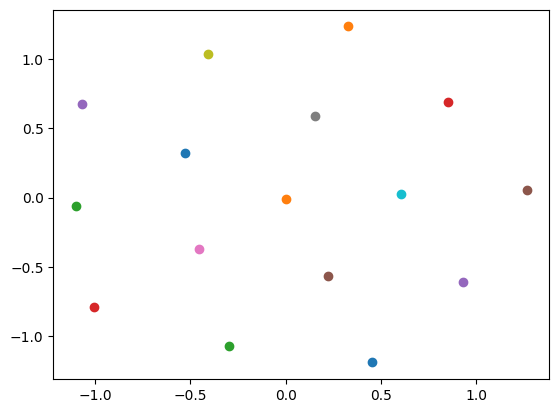

In [423]:
# Generate transmitted symbols using the encoder
tensor = torch.arange(16).to(device)
one_hot = F.one_hot(tensor, M).float()
tx = encoder(one_hot)
tx = tx.to("cpu").detach().numpy()
for i in range(M):
    plt.scatter(tx[i, 0], tx[i, 1])

constellation = np.array([tx[:, 0] + 1j * tx[:, 1]]).T

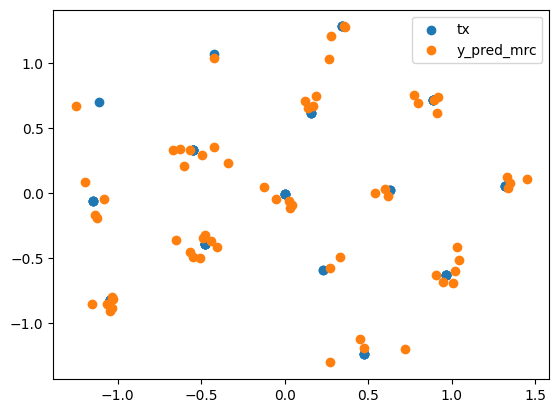

In [443]:
snr = 15
num_mess = 64  # number of messages to test
minErr = 1  # minimum number of errors
minSym = 1e6  # minimum number of symbols
totSym = 0  # total number of symbols
totErr_ae = 0  # total number of errors
totErr_mrc = 0  # total number of errors
messages = torch.randint(0, M, size=(num_mess,)).to(device)
one_hot = F.one_hot(messages).float()
tx = encoder(one_hot)
ch_real1 = torch.randn(tx.shape[0]).to(device)
ch_imag1 = torch.randn(tx.shape[0]).to(device)
ch_real2 = torch.randn(tx.shape[0]).to(device)
ch_imag2 = torch.randn(tx.shape[0]).to(device)
csi = torch.stack((ch_real1, ch_imag1, ch_real2, ch_imag2), dim=1)
rx_real1 = torch.mul(ch_real1, tx[:, 0]) - torch.mul(ch_imag1, tx[:, 1])
rx_imag1 = torch.mul(ch_imag1, tx[:, 0]) + torch.mul(ch_real1, tx[:, 1])
rx_real2 = torch.mul(ch_real2, tx[:, 0]) - torch.mul(ch_imag2, tx[:, 1])
rx_imag2 = torch.mul(ch_imag2, tx[:, 0]) + torch.mul(ch_real2, tx[:, 1])
rx = torch.stack((rx_real1, rx_imag1, rx_real2, rx_imag2), dim=1)
rx = awgn(rx, snr)

# Decoder receiver
rx_csi = torch.cat((rx, csi), dim=1)
y_pred_ae = decoder(rx_csi) 
pred_ae = torch.argmax(y_pred_ae, 1)
err = (pred_ae != messages).sum()
totErr_ae += err.cpu()

# MRC receiver
ch1 = np.array([ch_real1 + 1j * ch_imag1]).T
ch2 = np.array([ch_real2 + 1j * ch_imag2]).T
ch = np.hstack((ch1, ch2))
w = np.conj(ch) / np.sum(np.abs(ch)**2, axis=1, keepdims=True)
# Extract real and imaginary parts from rx
rx_real = rx[:, [0, 2]]  # Select columns containing real parts
rx_imag = rx[:, [1, 3]]  # Select columns containing imaginary parts
# Convert to numpy arrays and combine real and imaginary parts to form complex numbers
rx_complex = rx_real.detach().cpu().numpy() + 1j * rx_imag.detach().cpu().numpy()
y_pred_mrc =  np.sum(rx_complex * w, axis=1, keepdims=True)
# Calculate Euclidean distances between each point in rx_complex and each point in the constellation
distances = np.sqrt(np.sum(np.abs(y_pred_mrc[:, np.newaxis] - constellation)**2, axis=2))
# Find the index of the closest point in the constellation for each point in rx_complex
pred_mrc = np.argmin(distances, axis=1)
# calculate the number of errors
err = np.sum(pred_mrc != messages.cpu().numpy())
totErr_mrc += err

# plot tx, rx, and y_pred_mrc
tx = tx.to("cpu").detach().numpy()
plt.figure()
plt.scatter(tx[:, 0], tx[:, 1], label='tx')
# plt.scatter(rx_complex[:, 0], rx_complex[:, 1], label='rx')
plt.scatter(y_pred_mrc.real, y_pred_mrc.imag, label='y_pred_mrc')
plt.legend()
plt.show()



In [440]:
rx.shape

torch.Size([6400, 4])

loss:   0%|          | 0/11 [00:00<?, ?it/s]

loss: 100%|██████████| 11/11 [00:33<00:00,  3.03s/it]


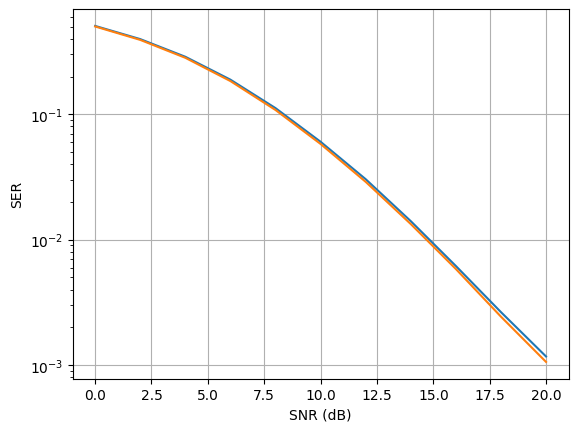

In [444]:
SNR_dB = np.arange(2, 22, 1)

# Monte Carlo simulation of the SER for the trained model and MRC receiver
SER_ae = np.array([])
SER_mrc = np.array([])
iteration = tqdm(range(len(SNR_dB)), desc="loss")
for iterator in iteration:
    snr = SNR_dB[iterator]
    num_mess = 6400  # number of messages to test
    minErr = 1  # minimum number of errors
    minSym = 1e6  # minimum number of symbols
    totSym = 0  # total number of symbols
    totErr_ae = 0  # total number of errors
    totErr_mrc = 0  # total number of errors
    while totErr_ae < minErr or totSym < minSym or totErr_mrc < minErr:
        messages = torch.randint(0, M, size=(num_mess,)).to(device)
        one_hot = F.one_hot(messages).float()
        tx = encoder(one_hot)
        ch_real1 = torch.randn(tx.shape[0]).to(device)
        ch_imag1 = torch.randn(tx.shape[0]).to(device)
        ch_real2 = torch.randn(tx.shape[0]).to(device)
        ch_imag2 = torch.randn(tx.shape[0]).to(device)
        csi = torch.stack((ch_real1, ch_imag1, ch_real2, ch_imag2), dim=1)
        rx_real1 = torch.mul(ch_real1, tx[:, 0]) - torch.mul(ch_imag1, tx[:, 1])
        rx_imag1 = torch.mul(ch_imag1, tx[:, 0]) + torch.mul(ch_real1, tx[:, 1])
        rx_real2 = torch.mul(ch_real2, tx[:, 0]) - torch.mul(ch_imag2, tx[:, 1])
        rx_imag2 = torch.mul(ch_imag2, tx[:, 0]) + torch.mul(ch_real2, tx[:, 1])
        rx = torch.stack((rx_real1, rx_imag1, rx_real2, rx_imag2), dim=1)
        rx = awgn(rx, snr)
        rx_csi = torch.cat((rx, csi), dim=1)

        # Decoder receiver
        y_pred_ae = decoder(rx_csi) 
        pred_ae = torch.argmax(y_pred_ae, 1)
        err_ae = (pred_ae != messages).sum()
        totErr_ae += err_ae.cpu()

        # MRC receiver
        ch1 = np.array([ch_real1 + 1j * ch_imag1]).T
        ch2 = np.array([ch_real2 + 1j * ch_imag2]).T
        ch = np.hstack((ch1, ch2))
        w = np.conj(ch) / np.sum(np.abs(ch)**2, axis=1, keepdims=True)
        # Extract real and imaginary parts from rx
        rx_real = rx[:, [0, 2]]  # Select columns containing real parts
        rx_imag = rx[:, [1, 3]]  # Select columns containing imaginary parts
        # Convert to numpy arrays and combine real and imaginary parts to form complex numbers
        rx_complex = rx_real.detach().cpu().numpy() + 1j * rx_imag.detach().cpu().numpy()
        y_pred_mrc =  np.sum(rx_complex * w, axis=1, keepdims=True)
        # Calculate Euclidean distances between each point in rx_complex and each point in the constellation
        distances = np.sqrt(np.sum(np.abs(y_pred_mrc[:, np.newaxis] - constellation)**2, axis=2))
        # Find the index of the closest point in the constellation for each point in rx_complex
        pred_mrc = np.argmin(distances, axis=1)
        # calculate the number of errors
        err = np.sum(pred_mrc != messages.cpu().numpy())
        totErr_mrc += err

        totSym += num_mess
    SER_ae = np.append(SER_ae, totErr_ae / totSym)
    SER_mrc = np.append(SER_mrc, totErr_mrc / totSym)



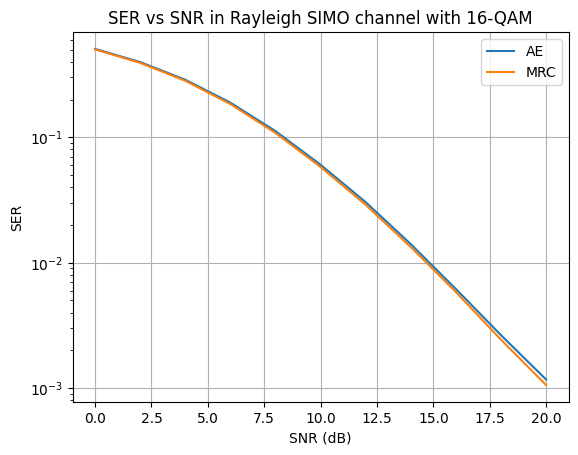

In [452]:
plt.figure()
plt.plot(SNR_dB, SER_ae, label="AE")
plt.plot(SNR_dB, SER_mrc, label="MRC")
plt.yscale("log")
plt.xlabel("SNR (dB)")
plt.ylabel("SER")
plt.grid()
plt.legend()
plt.title("SER vs SNR in Rayleigh SIMO channel with 16-QAM")
plt.show()

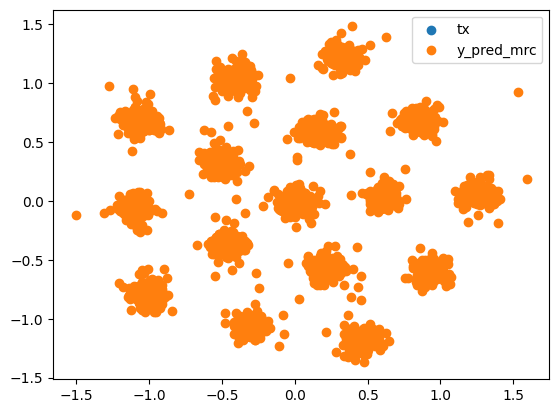

In [445]:
# plot tx, rx, and y_pred_mrc
tx = tx.to("cpu").detach().numpy()
plt.figure()
plt.scatter(tx[:, 0], tx[:, 1], label='tx')
# plt.scatter(rx_complex[:, 0], rx_complex[:, 1], label='rx')
plt.scatter(y_pred_mrc.real, y_pred_mrc.imag, label='y_pred_mrc')
plt.legend()
plt.show()

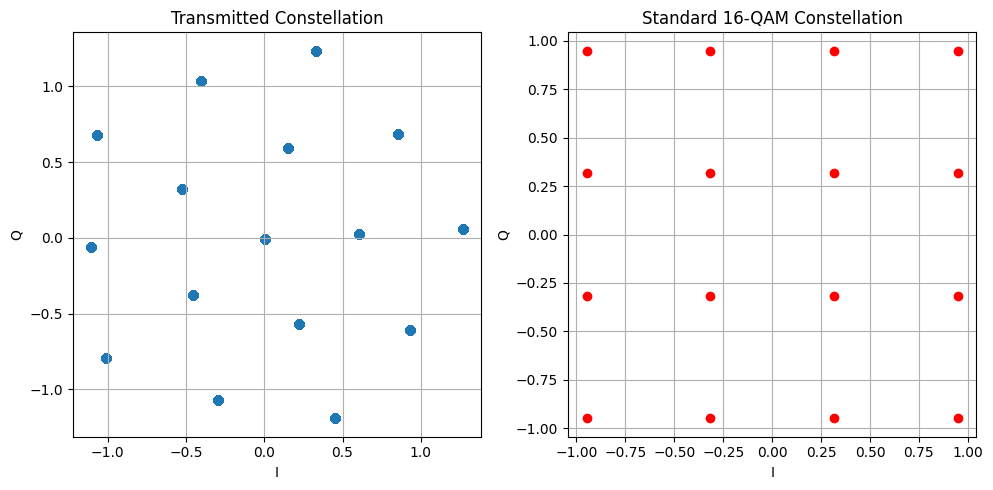

In [446]:
# Generate transmitted symbols using the encoder
num_mess = 6400  # number of messages to test
messages = torch.randint(0, M, size=(num_mess,)).to(device)
one_hot = F.one_hot(messages).float()
tx = encoder(one_hot)
tx = tx.to("cpu").detach().numpy()

# Define the coordinates for 16-QAM constellation points
points_I = np.array([1, 1, 1, 1, -1, -1, -1, -1, 3, 3, 3, 3, -3, -3, -3, -3]) / np.sqrt(10)
points_Q = np.array([3, 1, -1, -3, 3, 1, -1, -3, 3, 1, -1, -3, 3, 1, -1, -3]) / np.sqrt(10)

# Plot both constellations
plt.figure(figsize=(10, 5))

# Plot transmitted symbols
plt.subplot(1, 2, 1)
plt.scatter(tx[:, 0], tx[:, 1])
plt.xlabel("I")
plt.ylabel("Q")
plt.title("Transmitted Constellation")
plt.grid(True)

# Plot standard 16-QAM constellation
plt.subplot(1, 2, 2)
plt.scatter(points_I, points_Q, c="r")
plt.xlabel("I")
plt.ylabel("Q")
plt.title("Standard 16-QAM Constellation")
plt.grid(True)

plt.tight_layout()
plt.show()